In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Simulation of data for all models

Simulates data for N subjects for T periods in Heidues et al., Ba, Coutts et al. and the Bayesian benchmark. 

## Functions:

In [2]:
# a function that computes the expected probability of success under each effort choice
# given the belief about the omegas. The expected value muyt be computed separately for each type.
def Eu(prior, type_belief, M):
    # type belief should be 0, 1, or 2
    # the prior is over omegas. 
    # M is a vector of the three probability matrices (L, M, H)
    Eu = np.dot(M[type_belief], prior)
    return Eu

In [3]:
# a function that finds the effort level given the prior over omega
def choice(Eu_believed):
    e_index = np.argmax(Eu_believed)
    return e_index

In [4]:
# a function for the bayes update on omega
def bayesW(p0, e_index, o, M, believed_type):
    matrix = M[believed_type]
    row = matrix[e_index, :]
    if o == 1:
        p1 = np.diag(np.diagflat(p0)@np.diagflat(row))/np.sum(np.diag(np.diagflat(p0)@np.diagflat(row)))
    else:
        p1 = np.diag(np.diagflat(p0)@np.diagflat(1-row))/np.sum(np.diag(np.diagflat(p0)@np.diagflat(1-row)))
        
    return p1

In [12]:
# a function that updates omega and theta with a self serving attribution bias
def ss_update(gs_theta, gs_omega, gf_theta, gf_omega, p_omega, p_theta, e_index, o, M):

    matrix = np.array([M[0][e_index, :], M[2][e_index, :], M[2][e_index, :]])
    
    # g_theta and g_omega should have 3 elements: the distortion parameters for L, M and H. if all are equal to 1 
    # is the bayesian baseline.
    
    p0s_omega = np.diag(np.diagflat(p_omega) @ np.diagflat(gs_omega))
    p0s_theta = np.diag(np.diagflat(p_theta) @ np.diagflat(gs_theta))
    
    p0f_omega = np.diag(np.diagflat(p_omega) @ np.diagflat(gf_omega))
    p0f_theta = np.diag(np.diagflat(p_theta) @ np.diagflat(gf_theta))

    if o == 1:
        num_omega = np.diag( np.diagflat(p0s_omega) @ np.diagflat(np.array(p0s_theta) @ matrix ) )
        num_theta = np.diag( np.diagflat(p0s_theta) @ np.diagflat(matrix @ np.array(p0s_omega) ) )
        denom_o = np.sum(num_omega)
        denom_th = np.sum(num_theta)
        p1_omega = num_omega/denom_o
        p1_theta = num_theta/denom_th
    else:

        num_omega = np.diag( np.diagflat(p0f_omega) @ np.diagflat(np.array(p0f_theta) @ (1-matrix) ) )
        num_theta = np.diag( np.diagflat(p0f_theta) @ np.diagflat((1 - matrix ) @ np.array(p0f_omega) ) )
        denom_o = np.sum(num_omega)
        denom_th = np.sum(num_theta)
        p1_omega = num_omega/denom_o
        p1_theta = num_theta/denom_th
        
    return p1_theta, p1_omega

### Dogmatic types from Heidhues et al. (2018)

In [5]:
def sim_data(w_true, type_true, pi_0, T, N, M):
    # w_true is the exogenous parameter/exchange rate
    # type true is the true value of theta. 
    # prior is the prior over the three possible values of w 
    # T is the number of periods
    # N is the number of agents it will be simulated for
    #M is the matrices of probabilities under all three models

    # set the alternative types (misspecified models)
    type_L = 0
    type_M = 1
    type_H = 2

    pop_ew_L = []
    pop_ew_M = []
    pop_ew_H = []

    pop_choices_L = []
    pop_choices_M = []
    pop_choices_H = []

    pop_lr_L = []
    pop_lr_M = []
    pop_lr_H = []

    for n in range(N):
        # save the outcome history
        out_L = []
        out_M = []
        out_H = []

        # save the posterior history (bayes on $\omega$ with fixed $\theta$)
        pw_L = [pi_0]
        pw_M = [pi_0]
        pw_H = [pi_0] 

        #save the vectors of probabilities under the believed model and under the true model (to compute the likelihhod ratio)
        p_L_model = []
        p_M_model = []
        p_H_model = []

        p_L_true = []
        p_M_true = []
        p_H_true = []

        # save the likelihood
        likelihood_L = [1]
        likelihood_M = [1]
        likelihood_H =[1]

        # save the effort history
        e_L = []
        e_M = []
        e_H = []

        # the starting beliefs for each type
        p0_L = pi_0
        p0_M = pi_0
        p0_H = pi_0

        # the expected value of $\omega$
        Ew_L = [np.dot([0, 1, 2], pi_0)]
        Ew_M = [np.dot([0, 1, 2], pi_0)]
        Ew_H = [np.dot([0, 1, 2], pi_0)]
        
        # simulate a single agent for T periods
        for i in range(T):
            #compute the expected success rate from every choice
            Eu_H = Eu(p0_H, 2, M)
            Eu_M = Eu(p0_M, 1, M)
            Eu_L = Eu(p0_L, 0, M)

            # save the effort that maximizes their success rate in the effort history vector
            choice_H = choice( Eu_H ) 
            choice_M = choice( Eu_M ) 
            choice_L = choice( Eu_L ) 

            # Draw a realization using the probability under the true type, for a given true $\omega$5
            outcome_H = np.random.binomial(1, M[type_true][choice_H, w_true], size=None)
            outcome_M = np.random.binomial(1, M[type_true][choice_M, w_true], size=None)
            outcome_L = np.random.binomial(1, M[type_true][choice_L, w_true], size=None)

            # update the belief on omega given the outcome
            p1_H = bayesW(p0_H, choice_H, outcome_H, M, type_H)
            p1_L = bayesW(p0_L, choice_L, outcome_L, M, type_L)
            p1_M = bayesW(p0_M, choice_M, outcome_M, M, type_M )

            # compute the likelihood ratio of the true type over their believed type.
            # First save all the probabilities of the realized types
            if outcome_H == 1:
                p_H_model.append(M[type_H][choice_H, :])
                p_H_true.append(M[type_true][choice_H, :])

            else:
                p_H_model.append(1 - M[type_H][choice_H, :])
                p_H_true.append(1 - M[type_true][choice_H, :])

            if outcome_L == 1:
                p_L_model.append(M[type_L][choice_L, :])
                p_L_true.append(M[type_true][choice_L, :])
            else:
                p_L_model.append(1 - M[type_L][choice_L, :])
                p_L_true.append(1 - M[type_true][choice_L, :])
                
            if outcome_M == 1:
                p_M_model.append(M[type_M][choice_M, :])
                p_M_true.append(M[type_true][choice_M, :])
            else:
                p_M_model.append(1 - M[type_M][choice_M, :])
                p_M_true.append(1 - M[type_true][choice_M, :])
                
            
            # compute the likelihoods for each model and alternative (the models are the believed types and the alternative is always the truth)
            likelihood_H.append(np.dot(np.prod(np.array(p_H_true), axis=0), pi_0)/np.dot(np.prod(np.array(p_H_model), axis=0), pi_0))
            likelihood_L.append(np.dot(np.prod(np.array(p_L_true), axis=0), pi_0)/np.dot(np.prod(np.array(p_L_model), axis=0), pi_0))
            likelihood_M.append(np.dot(np.prod(np.array(p_M_true), axis=0), pi_0)/np.dot(np.prod(np.array(p_M_model), axis=0), pi_0))
            

            # their expectation of $\omega$ each period
            Ew_H.append(np.dot([0, 1, 2], p1_H))
            Ew_L.append(np.dot([0, 1, 2], p1_L))
            Ew_M.append(np.dot([0, 1, 2], p1_M))

            # add to the history vector of outcomes
            out_H.append( outcome_H )
            out_M.append( outcome_M )
            out_L.append( outcome_L )

            # add to the history of beliefs and update the prior
            # save the effort that maximizes their success rate in the effort history vector
            e_H.append( choice_H )
            e_M.append( choice_M )
            e_L.append( choice_L )

            pw_H.append( p1_H )
            pw_M.append( p1_M )
            pw_L.append( p1_L )

            p0_H = p1_H
            p0_M = p1_M
            p0_L = p1_L

        pop_ew_H.append(Ew_H)
        pop_ew_L.append(Ew_L)
        pop_ew_M.append(Ew_M)

        pop_choices_H.append(e_H)
        pop_choices_L.append(e_L)
        pop_choices_M.append(e_M)

        pop_lr_H.append( likelihood_H )
        pop_lr_L.append( likelihood_L )
        pop_lr_M.append( likelihood_M )

    # turn each table into a data frame
    df_ew_H = pd.DataFrame(pop_ew_H)
    df_ew_L = pd.DataFrame(pop_ew_L)
    df_ew_M = pd.DataFrame(pop_ew_M)

    df_choices_H = pd.DataFrame(pop_choices_H)
    df_choices_L = pd.DataFrame(pop_choices_L)
    df_choices_M = pd.DataFrame(pop_choices_M)

    df_lr_H = pd.DataFrame(pop_lr_H)
    df_lr_L = pd.DataFrame(pop_lr_L)
    df_lr_M = pd.DataFrame(pop_lr_M)

    df_ew_H.columns = ['ew_H'+str(t) for t in range(T+1)]
    df_ew_L.columns = ['ew_L'+str(t) for t in range(T+1)]
    df_ew_M.columns = ['ew_M'+str(t) for t in range(T+1)]

    df_choices_H.columns = ['choice_H'+str(t) for t in range(T)]
    df_choices_L.columns = ['choice_L'+str(t) for t in range(T)]
    df_choices_M.columns = ['choice_M'+str(t) for t in range(T)]

    df_lr_H.columns = ['lr_H'+str(t) for t in range(T+1)]
    df_lr_L.columns = ['lr_L'+str(t) for t in range(T+1)]
    df_lr_M.columns = ['lr_M'+str(t) for t in range(T+1)]

    # go from multiple wide data frame to a single long one for $\omega_L$
    df = pd.concat([df_ew_H, 
                   df_ew_L, 
                   df_ew_M, 
                   df_choices_H, 
                   df_choices_L, 
                   df_choices_M, 
                   df_lr_H, 
                   df_lr_L,
                   df_lr_M], axis=1)

    df["id"] = df.index

    df = pd.wide_to_long(df, ["ew_H", 
                                  "ew_L", 
                                  "ew_M", 
                                  "choice_H", 
                                  "choice_L", 
                                  "choice_M", 
                                  "lr_H",
                                  "lr_L", 
                                  "lr_M"], 
                             i="id", j="year")


    return df

### Likelihood ratio test from Ba (2022)

In [6]:
def lr_indiv(w_true, type_true, type_belief, T, M, pi_0, alpha):
    # save the outcome history
    out = []
    types = [type_belief]

        # save the posterior history (bayes on $\omega$ with fixed $\theta$)
    pw = [pi_0] 

        #save the vectors of probabilities under the believed model and under the true model (to compute the likelihhod ratio)
    p_model = []

    p_true = []

        # save the likelihood
    likelihood = [1]

        # save the effort history
    e = []

        # the starting beliefs for each type
    p0 = pi_0

        # the expected value of $\omega$
    Ew = [np.dot([0, 1, 2], pi_0)]
        
        # simulate a single agent for T periods
    for i in range(T):
            #compute the expected success rate from every choice
        u = Eu(p0, type_belief, M)

            # save the effort that maximizes their success rate in the effort history vector
        chose = choice( u )  

            # Draw a realization using the probability under the true type, for a given true $\omega$5
        outcome = np.random.binomial(1, M[type_true][chose, w_true], size=None)

            # update the belief on omega given the outcome
        p1 = bayesW(p0, chose, outcome, M, type_belief)

        # compute the likelihood ratio of the true type over their believed type.
        # First save all the probabilities of the realized types
        if outcome == 1:
            p_model.append(M[type_belief][chose, :])
            p_true.append(M[type_true][chose, :])

        else:
            p_model.append(1 - M[type_belief][chose, :])
            p_true.append(1 - M[type_true][chose, :])
                
        LR = np.dot(np.prod(np.array(p_true), axis=0), pi_0)/np.dot(np.prod(np.array(p_model), axis=0), pi_0)
            
        if LR > alpha:
            type_belief = type_true
            types.append(type_belief)
        else:
            type_belief = type_belief
            types.append(type_belief)
            
            # compute the likelihoods for each model and alternative (the models are the believed types and the alternative is always the truth)
        likelihood.append(LR)  

            # their expectation of $\omega$ each period
        Ew.append(np.dot([0, 1, 2], p1))

            # add to the history vector of outcomes
        out.append( outcome )

            # add to the history of beliefs and update the prior
            # save the effort that maximizes their success rate in the effort history vector
        e.append( chose )

        pw.append( p1 )

        p0 = p1
        
    d = {'Ew': Ew[1:], 'choice': e, 'types':types[1:], 'outcomes': out, 'lr':likelihood[1:]}
    df = pd.DataFrame(d)
    
    return df


def lr_sim(w_true, type_true, T, N, M, pi_0, alpha):
    df = pd.DataFrame({ "index":[],
                             "Ew_L": [], 
                             "choice_L": [], 
                             "types_L":[], 
                             "outcomes_L": [], 
                             "lr_L":[],
                       
                             "Ew_M": [], 
                             "choice_M": [], 
                             "types_M":[], 
                             "outcomes_M": [], 
                             "lr_M":[],
                       
                             "Ew_H": [], 
                             "choice_H": [], 
                             "types_H":[], 
                             "outcomes_H": [], 
                             "lr_H":[], 
                      "id":[]})
    for n in range(N):
        df_L = lr_indiv(w_true, type_true, 0, T, M, pi_0, alpha)
        
        df_L = df_L.rename(columns={ 
                             "Ew": "Ew_L", 
                             "choice": "choice_L", 
                             "types":"types_L", 
                             "outcomes": "outcomes_L", 
                             "lr":"lr_L"})
        df_M = lr_indiv(w_true, type_true, 1, T, M, pi_0, alpha)
        
        df_M = df_M.rename(columns={
                             "Ew": "Ew_M", 
                             "choice": "choice_M", 
                             "types":"types_M", 
                             "outcomes": "outcomes_M", 
                             "lr":"lr_M"})
        df_H = lr_indiv(w_true, type_true, 2, T, M, pi_0, alpha)
        
        df_H = df_H.rename(columns={
                             "Ew": "Ew_H", 
                             "choice": "choice_H", 
                             "types":"types_H", 
                             "outcomes": "outcomes_H", 
                             "lr":"lr_H"})
        dt = pd.concat([df_L, df_M, df_H], axis = 1)
        dt['id'] = n
        dt.reset_index(inplace=True)
        df = pd.concat([df, dt], ignore_index=True, sort=False)
    return df

### Self-Serving attribution bias

In [7]:
def ss_simulation(w_true, type_true, T, N, M, pi_omega , pi_theta, gs_theta, gs_omega, gf_theta, gf_omega):
    # gs and gf should be vectors with 3 elements. each element is the ss distortion parameter for low mid and high types 
    #respectively. s stands for a success and f for a failure. a gs_theta_3>1 is an attribution to the high type after a success.
    # It should be accompanied by a gs_omega_3<1 which takes away weight from the high omega after a success. 
    #after failures, it shoulf be a high weight to low omega and a low weight to a low theta.
    
    pop_ss_omega = []
    pop_ss_theta = []

    pop_choices = []
    
    for i in range(N):
        
        ss_omega = [pi_omega]
        ss_theta = [pi_theta]
        
        p0_theta = pi_theta
        p0_omega = pi_omega
        
        effort = []
        
        Ew = [np.dot([0, 1, 2], p0_omega)]
        Eth = [np.dot([0, 1, 2], p0_theta)]
        
        outcomes = []
        
        for t in range(T):
            
            
            #compute the expected success rate from every choice
            Eu = p0_theta @ np.array([np.dot(M[0], p0_omega), np.dot(M[1], p0_omega), np.dot(M[2], p0_omega)])
            
            # save the effort that maximizes their success rate in the effort history vector
            e = np.argmax( Eu )  

            # Draw a realization using the probability under the true type, for a given true $\omega$5
            outcome = np.random.binomial(1, M[type_true][e, w_true], size=None)

            # update the belief on omega given the outcome
        
            p1_theta, p1_omega = ss_update(gs_theta, gs_omega, gf_theta, gf_omega, p0_omega, p0_theta, e, outcome, M)
            
            # their expectation of $\omega$ each period
            Ew.append(np.dot([0, 1, 2], p1_omega))
            Eth.append(np.dot([0, 1, 2], p1_theta))

            # add to the history vector of outcomes
            outcomes.append( outcome )

            # add to the history of beliefs and update the prior
            # save the effort that maximizes their success rate in the effort history vector
            effort.append( e )

            ss_theta.append( p1_theta )
            ss_omega.append( p1_omega )

            p0_theta = p1_theta
            p0_omega = p1_omega

        pop_ss_omega.append(Ew)
        pop_ss_theta.append(Eth)

        pop_choices.append(effort)
        
        

    # turn each table into a data frame
    df_ew = pd.DataFrame(pop_ss_omega)

    df_choices = pd.DataFrame(pop_choices)

    df_eth = pd.DataFrame(pop_ss_theta)

    df_ew.columns = ['ew'+str(t) for t in range(T+1)]
    
    df_eth.columns = ['eth'+str(t) for t in range(T+1)]

    df_choices.columns = ['choice'+str(t) for t in range(T)]

    # go from multiple wide data frame to a single long one for $\omega_L$
    df = pd.concat([df_ew,
                    df_eth,
                    df_choices, 
                    ], axis=1)

    df["id"] = df.index

    df = pd.wide_to_long(df, ["ew", 
                                "eth", 
                                "choice"], 
                             i="id", j="year")


    return df

# Simulate all data
Generates one data frame per model. 

In [16]:
# the probabilities of success.
ML = np.array([[.20, .40, .50], [.15, .45, .60], [.05, .40, .65]])
MM = np.array([[.30, .50, .75], [.25, .60, .70], [.05, .45, .80]])
MH = np.array([[.40, .65, .90], [.35, .70, .95], [.20, .65, 1]])

M = [ML, MM, MH]

In [17]:
print(ML)
print(MM)
print(MH)

[[0.2  0.4  0.5 ]
 [0.15 0.45 0.6 ]
 [0.05 0.4  0.65]]
[[0.3  0.5  0.75]
 [0.25 0.6  0.7 ]
 [0.05 0.45 0.8 ]]
[[0.4  0.65 0.9 ]
 [0.35 0.7  0.95]
 [0.2  0.65 1.  ]]


In [83]:
M = [ML, MM, MH]
pi_0 = [1/3, 1/3, 1/3]
N = 1000
T = 100

alpha = 1 

# Dogmatic belief on theta
df_00 = sim_data(0, 0, pi_0, T, N, M)
df_10 = sim_data(1, 0, pi_0, T, N, M)
df_20 = sim_data(2, 0, pi_0, T, N, M)
df_01 = sim_data(0, 1, pi_0, T, N, M)
df_11 = sim_data(1, 1, pi_0, T, N, M)
df_21 = sim_data(2, 1, pi_0, T, N, M)
df_02 = sim_data(0, 2, pi_0, T, N, M)
df_12 = sim_data(1, 2, pi_0, T, N, M)
df_22 = sim_data(2, 2, pi_0, T, N, M)

df_00.reset_index(inplace=True)
df_10.reset_index(inplace=True)
df_20.reset_index(inplace=True)
df_01.reset_index(inplace=True)
df_11.reset_index(inplace=True)
df_21.reset_index(inplace=True)
df_02.reset_index(inplace=True)
df_12.reset_index(inplace=True)
df_22.reset_index(inplace=True)

df_00['omega'] = 0
df_00['theta'] = 0

df_10['omega'] = 1
df_10['theta'] = 0

df_20['omega'] = 2
df_20['theta'] = 0

df_01['omega'] = 0
df_01['theta'] = 1

df_11['omega'] = 1
df_11['theta'] = 1

df_21['omega'] = 2
df_21['theta'] = 1

df_02['omega'] = 0
df_02['theta'] = 2

df_12['omega'] = 1
df_12['theta'] = 2

df_22['omega'] = 2
df_22['theta'] = 2

dd = pd.concat([df_00, df_10, df_20, df_01, df_11, df_21, df_02, df_12, df_22], ignore_index=True, sort=False)

#likelihood ratio test on theta
lr_00 = lr_sim(0, 0, T, N, M, pi_0, alpha)
lr_10 = lr_sim(1, 0, T, N, M, pi_0, alpha)
lr_20 = lr_sim(2, 0, T, N, M, pi_0, alpha)

lr_01 = lr_sim(0, 1, T, N, M, pi_0, alpha)
lr_11 = lr_sim(1, 1, T, N, M, pi_0, alpha)
lr_21 = lr_sim(2, 1, T, N, M, pi_0, alpha)

lr_02 = lr_sim(0, 2, T, N, M, pi_0, alpha)
lr_12 = lr_sim(1, 2, T, N, M, pi_0, alpha)
lr_22 = lr_sim(2, 2, T, N, M, pi_0, alpha)

lr_00['omega'] = 0
lr_00['theta'] = 0

lr_10['omega'] = 1
lr_10['theta'] = 0

lr_20['omega'] = 2
lr_20['theta'] = 0

lr_01['omega'] = 0
lr_01['theta'] = 1

lr_11['omega'] = 1
lr_11['theta'] = 1

lr_21['omega'] = 2
lr_21['theta'] = 1

lr_02['omega'] = 0
lr_02['theta'] = 2

lr_12['omega'] = 1
lr_12['theta'] = 2

lr_22['omega'] = 2
lr_22['theta'] = 2

lr = pd.concat([lr_00, lr_10, lr_20, lr_01, lr_11, lr_21, lr_02, lr_12, lr_22], ignore_index=True, sort=False)



In [84]:
pi_omega = pi_0
pi_theta = [1/4, 1/4, 1/2]
gs_theta = [1, 1, 1.2]
gs_omega = [1, 1, .8]
gf_theta = [.8, 1, 1]
gf_omega = [1.2, 1, 1]
g_bay = [1, 1, 1]

#Self serving bias and bayesian updating
ss_00 = ss_simulation(0, 0, T, N, M, pi_omega , pi_theta, gs_theta, gs_omega, gf_theta, gf_omega)
bay_00 = ss_simulation(0, 0, T, N, M, pi_omega , pi_theta, g_bay, g_bay, g_bay, g_bay)

ss_10 = ss_simulation(1, 0, T, N, M, pi_omega , pi_theta, gs_theta, gs_omega, gf_theta, gf_omega)
bay_10 = ss_simulation(1, 0, T, N, M, pi_omega , pi_theta, g_bay, g_bay, g_bay, g_bay)

ss_20 = ss_simulation(2, 0, T, N, M, pi_omega , pi_theta, gs_theta, gs_omega, gf_theta, gf_omega)
bay_20 = ss_simulation(2, 0, T, N, M, pi_omega , pi_theta, g_bay, g_bay, g_bay, g_bay)

ss_01 = ss_simulation(0, 1, T, N, M, pi_omega , pi_theta, gs_theta, gs_omega, gf_theta, gf_omega)
bay_01 = ss_simulation(0, 1, T, N, M, pi_omega , pi_theta, g_bay, g_bay, g_bay, g_bay)

ss_11 = ss_simulation(1, 1, T, N, M, pi_omega , pi_theta, gs_theta, gs_omega, gf_theta, gf_omega)
bay_11 = ss_simulation(1, 1, T, N, M, pi_omega , pi_theta, g_bay, g_bay, g_bay, g_bay)

ss_21 = ss_simulation(2, 1, T, N, M, pi_omega , pi_theta, gs_theta, gs_omega, gf_theta, gf_omega)
bay_21 = ss_simulation(2, 1, T, N, M, pi_omega , pi_theta, g_bay, g_bay, g_bay, g_bay)

ss_02 = ss_simulation(0, 2, T, N, M, pi_omega , pi_theta, gs_theta, gs_omega, gf_theta, gf_omega)
bay_02 = ss_simulation(0, 2, T, N, M, pi_omega , pi_theta, g_bay, g_bay, g_bay, g_bay)

ss_12 = ss_simulation(1, 2, T, N, M, pi_omega , pi_theta, gs_theta, gs_omega, gf_theta, gf_omega)
bay_12 = ss_simulation(1, 2, T, N, M, pi_omega , pi_theta, g_bay, g_bay, g_bay, g_bay)

ss_22 = ss_simulation(2, 2, T, N, M, pi_omega , pi_theta, gs_theta, gs_omega, gf_theta, gf_omega)
bay_22 = ss_simulation(2, 2, T, N, M, pi_omega , pi_theta, g_bay, g_bay, g_bay, g_bay)

ss_00.reset_index(inplace=True)
ss_10.reset_index(inplace=True)
ss_20.reset_index(inplace=True)
ss_01.reset_index(inplace=True)
ss_11.reset_index(inplace=True)
ss_21.reset_index(inplace=True)
ss_02.reset_index(inplace=True)
ss_12.reset_index(inplace=True)
ss_22.reset_index(inplace=True)

bay_00.reset_index(inplace=True)
bay_10.reset_index(inplace=True)
bay_20.reset_index(inplace=True)
bay_01.reset_index(inplace=True)
bay_11.reset_index(inplace=True)
bay_21.reset_index(inplace=True)
bay_02.reset_index(inplace=True)
bay_12.reset_index(inplace=True)
bay_22.reset_index(inplace=True)

ss_00['omega'] = 0
ss_00['theta'] = 0

ss_10['omega'] = 1
ss_10['theta'] = 0

ss_20['omega'] = 2
ss_20['theta'] = 0

ss_01['omega'] = 0
ss_01['theta'] = 1

ss_11['omega'] = 1
ss_11['theta'] = 1

ss_21['omega'] = 2
ss_21['theta'] = 1

ss_02['omega'] = 0
ss_02['theta'] = 2

ss_12['omega'] = 1
ss_12['theta'] = 2

ss_22['omega'] = 2
ss_22['theta'] = 2

ss = pd.concat([ss_00, ss_10, ss_20, ss_01, ss_11, ss_21, ss_02, ss_12, ss_22], ignore_index=True, sort=False)

bay_00['omega'] = 0
bay_00['theta'] = 0

bay_10['omega'] = 1
bay_10['theta'] = 0

bay_20['omega'] = 2
bay_20['theta'] = 0

bay_01['omega'] = 0
bay_01['theta'] = 1

bay_11['omega'] = 1
bay_11['theta'] = 1

bay_21['omega'] = 2
bay_21['theta'] = 1

bay_02['omega'] = 0
bay_02['theta'] = 2

bay_12['omega'] = 1
bay_12['theta'] = 2

bay_22['omega'] = 2
bay_22['theta'] = 2
bay = pd.concat([bay_00, bay_10, bay_20, bay_01, bay_11, bay_21, bay_02, bay_12, bay_22], ignore_index=True, sort=False)

In [85]:
bay['model'] = 'bay'
ss_gH20['model'] = 'ss'
lr['model'] = 'lr'
dd['model'] = 'dog'

In [86]:
ss = ss_gH20

In [87]:
lr.rename(columns={"index": "year"}, inplace=True)

In [88]:
def hist_time(omega, theta):    
    sns.set_theme(style="ticks")
    fig, axes = plt.subplots(3, 3, figsize=(15, 7))
    sns.despine(fig)
    
    pal = "Accent"

    sns.histplot(ax=axes[0, 0],
        data=dd[(dd.omega == omega) & (dd.theta == theta)],
        x="year", hue="choice_L",
        multiple="stack",
        palette=pal,
        edgecolor=".3",
        linewidth=.1,
        binwidth=1,
        binrange=[0, 100]
    )

    sns.histplot(ax=axes[0, 1],
        data=dd[(dd.omega == omega) & (dd.theta == theta)],
        x="year", hue="choice_M",
        multiple="stack",
        palette=pal,
        edgecolor=".3",
        linewidth=.1,
        binwidth=1,
        binrange=[0, 100]
    )

    sns.histplot(ax=axes[0, 2],
        data=dd[(dd.omega == omega) & (dd.theta == theta)],
        x="year", hue="choice_H",
        multiple="stack",
        palette=pal,
        edgecolor=".3",
        linewidth=.1,
        binwidth=1,
        binrange=[0, 100]
    )

    sns.histplot(ax=axes[1, 0],
        data=lr[(lr.omega == omega) & (lr.theta == theta)],
        x="year", hue="choice_L",
        multiple="stack",
        palette=pal,
        edgecolor=".3",
        linewidth=.1,
        binwidth=1,
        binrange=[0, 100]
    )
    
    sns.histplot(ax=axes[1, 1],
        data=lr[(lr.omega == omega) & (lr.theta==theta)],
        x="year", hue="choice_M",
        multiple="stack",
        palette=pal,
        edgecolor=".3",
        linewidth=.1,
        binwidth=1,
        binrange=[0, 100]
    )
    
    
    sns.histplot(ax=axes[1, 2],
        data=lr[(lr.omega == omega) & (lr.theta==theta)],
        x="year", hue="choice_H",
        multiple="stack",
        palette=pal,
        edgecolor=".3",
        linewidth=.1,
        binwidth=1,
        binrange=[0, 100]
    )
   
    
    sns.histplot(ax=axes[2, 0],
        data=ss[(ss.omega == omega) & (ss.theta==theta)],
        x="year", hue="choice",
        multiple="stack",
        palette=pal,
        edgecolor=".3",
        linewidth=.1,
        binwidth=1,
        binrange=[0, 100]
    )
    
    sns.histplot(ax=axes[2, 1],
        data=bay[(bay.omega == omega) & (bay.theta==theta)],
        x="year", hue="choice",
        multiple="stack",
        palette=pal,
        edgecolor=".3",
        linewidth=.1,
        binwidth=1,
        binrange=[0, 100]
    )

In [89]:
def line_time(omega, theta, n):    
    sns.set_theme(style="ticks")
    fig, axes = plt.subplots(3, 3, figsize=(15, 7))
    sns.despine(fig)
    
    pal = "rocket"

    sns.lineplot(ax=axes[0, 0],
        data=dd[(dd.omega == omega) & (dd.theta == theta) & (dd.id < n)],
        x="year", y="choice_L", hue="id",
        palette=pal, lw=1, estimator=None
    )
    axes[0,0].set_ylim(0,2)
    axes[0, 0].legend([],[], frameon=False)

    sns.lineplot(ax=axes[0, 1],
        data=dd[(dd.omega == omega) & (dd.theta == theta) & (dd.id < n)],
        x="year", y="choice_M", hue = "id",
        palette=pal, lw=1, estimator=None
    )
    axes[0,1].set_ylim(0,2)
    axes[0, 1].legend([],[], frameon=False)

    sns.lineplot(ax=axes[0, 2],
        data=dd[(dd.omega == omega) & (dd.theta == theta) & (dd.id < n)],
        x="year", y="choice_H", hue="id",
        palette=pal, lw=1, estimator=None
    )
    axes[0,2].set_ylim(0,2)
    axes[0, 2].legend([],[], frameon=False)

    sns.lineplot(ax=axes[1, 0],
        data=lr[(lr.omega == omega) & (lr.theta == theta) & (lr.id < n)],
        x="year", y="choice_L", hue = "id",
        palette=pal, lw=1, estimator=None
    )
    axes[1,0].set_ylim(0,2)
    axes[1, 0].legend([],[], frameon=False)
    
    
    sns.lineplot(ax=axes[1, 1],
        data=lr[(lr.omega == omega) & (lr.theta == theta) & (lr.id < n)],
        x="year", y="choice_M", hue="id",
        palette=pal, lw=1, estimator=None
    )
    axes[1,1].set_ylim(0,2)
    axes[1, 1].legend([],[], frameon=False)
    
    
    sns.lineplot(ax=axes[1, 2],
        data=lr[(lr.omega == omega) & (lr.theta == theta) & (lr.id < n)],
        x="year", y="choice_H", hue='id',
        palette=pal, lw=1, estimator=None
    )
    axes[1,2].set_ylim(0,2)
    axes[1, 2].legend([],[], frameon=False)
   
    
    sns.lineplot(ax=axes[2, 0],
        data=ss[(ss.omega == omega) & (ss.theta==theta) & (ss.id < n)],
        x="year", y="choice", hue='id',
        palette=pal, lw=1, estimator=None
    )
    axes[2,0].set_ylim(0,2)
    axes[2, 0].legend([],[], frameon=False)
    
    sns.lineplot(ax=axes[2, 1],
        data=bay[(bay.omega == omega) & (bay.theta == theta) & (bay.id < n)],
        x="year", y="choice", hue='id',
        palette=pal, lw=1, estimator=None
    )
    axes[2,1].set_ylim(0,2)
    axes[2, 1].legend([],[], frameon=False)

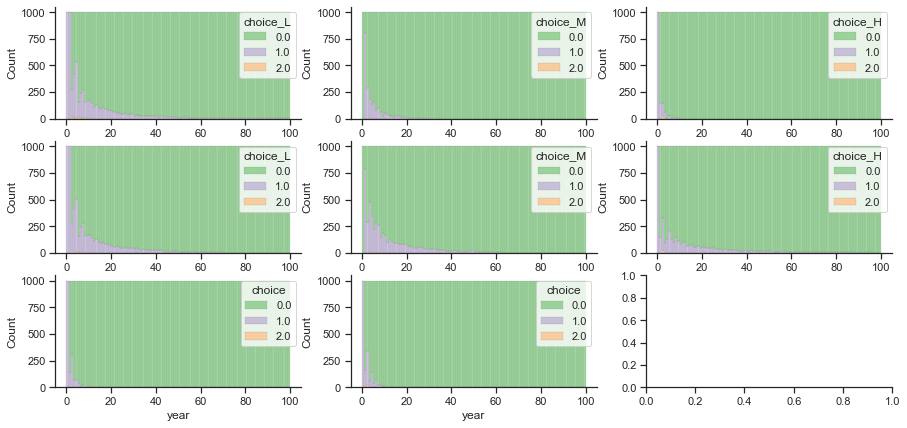

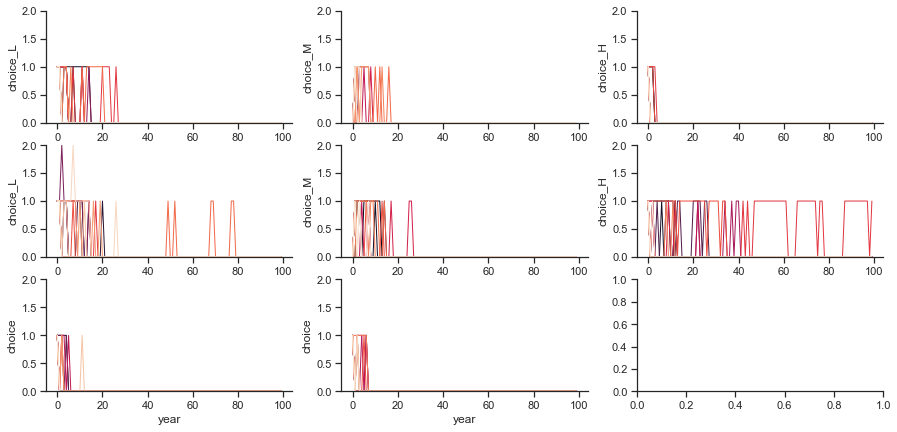

In [90]:
hist_time(0, 0)
line_time(0, 0, 20)

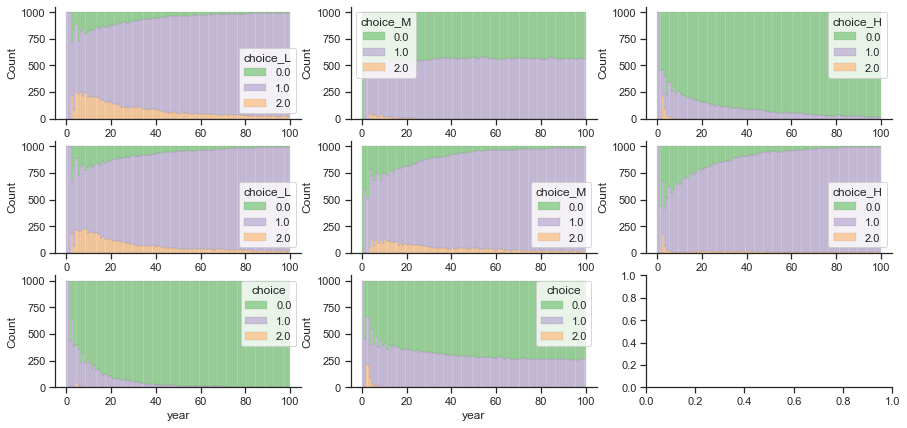

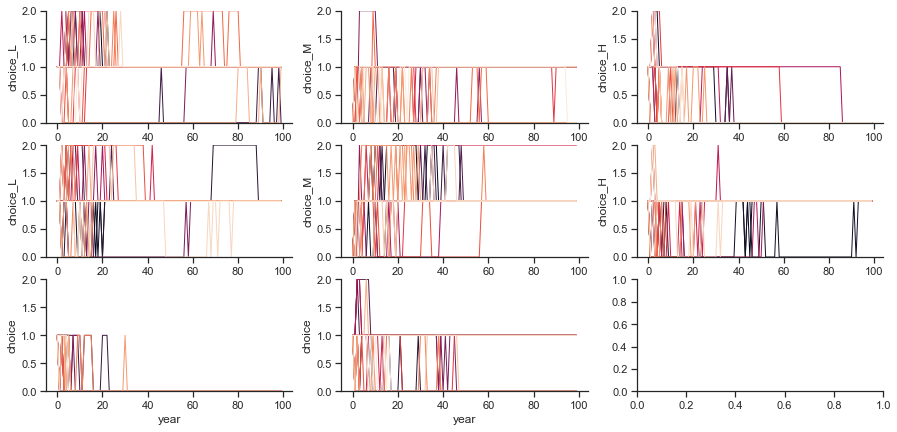

In [91]:
hist_time(1, 0)
line_time(1, 0, 20)

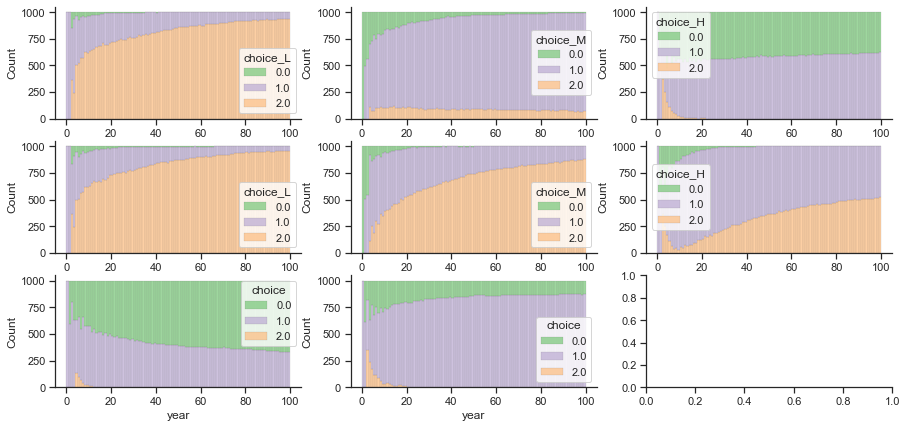

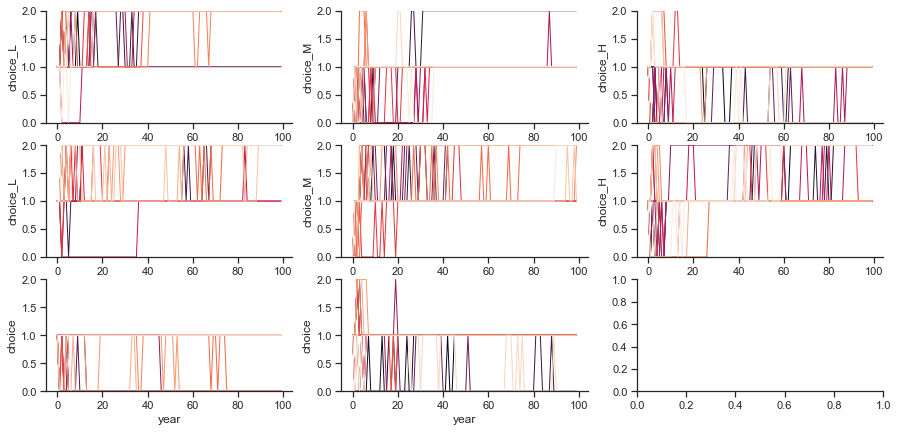

In [92]:
hist_time(2, 0)
line_time(2, 0, 20)

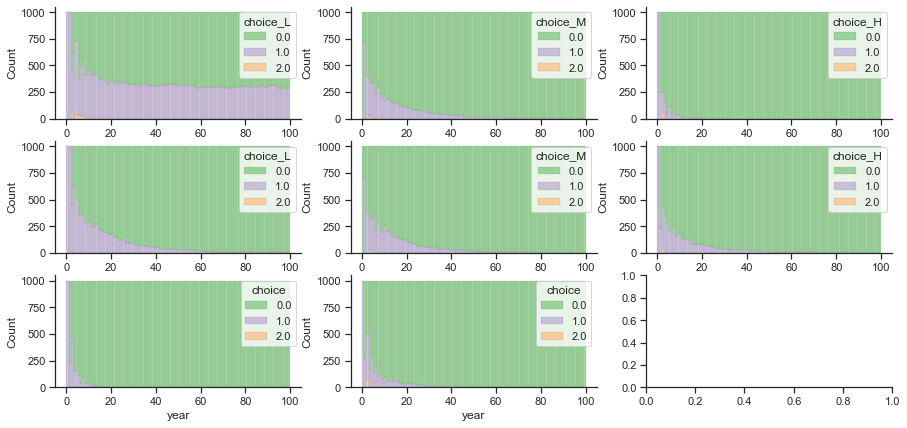

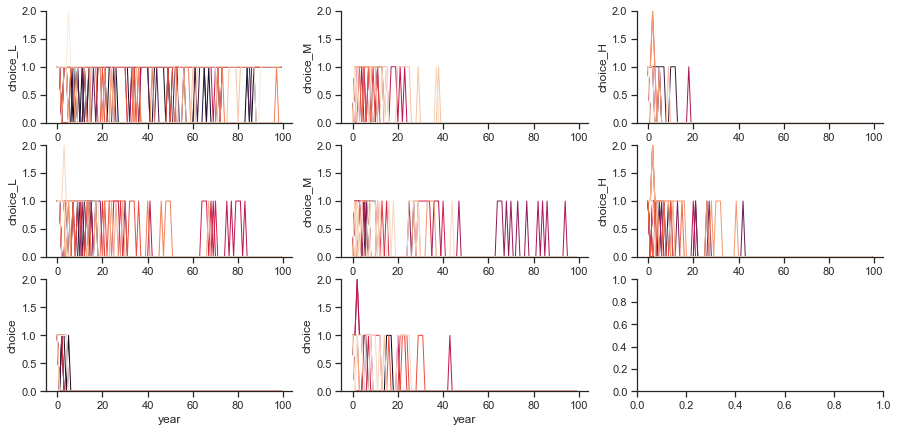

In [93]:
hist_time(0, 1)
line_time(0, 1, 20)

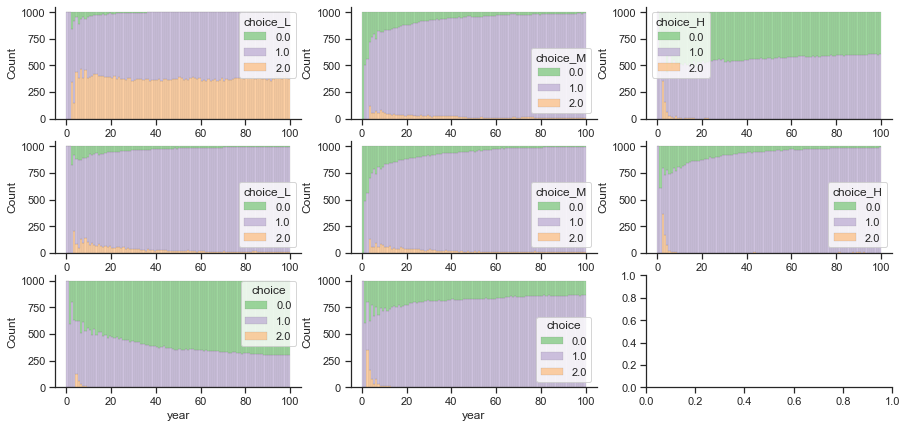

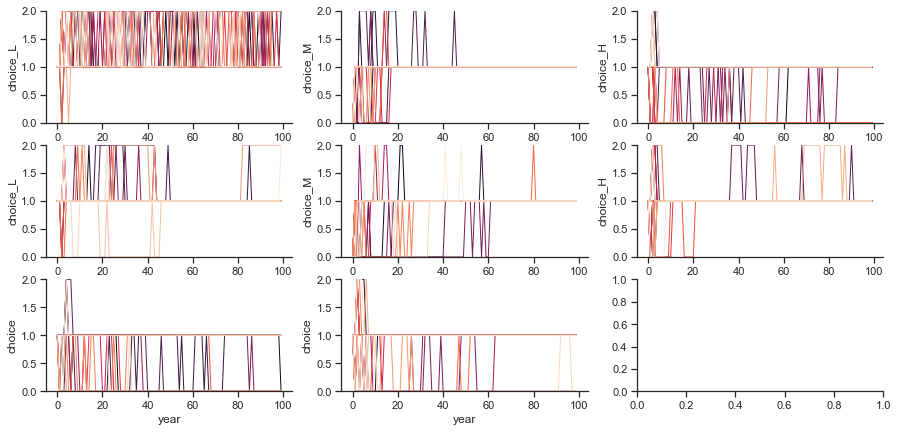

In [94]:
hist_time(1, 1)
line_time(1, 1, 20)

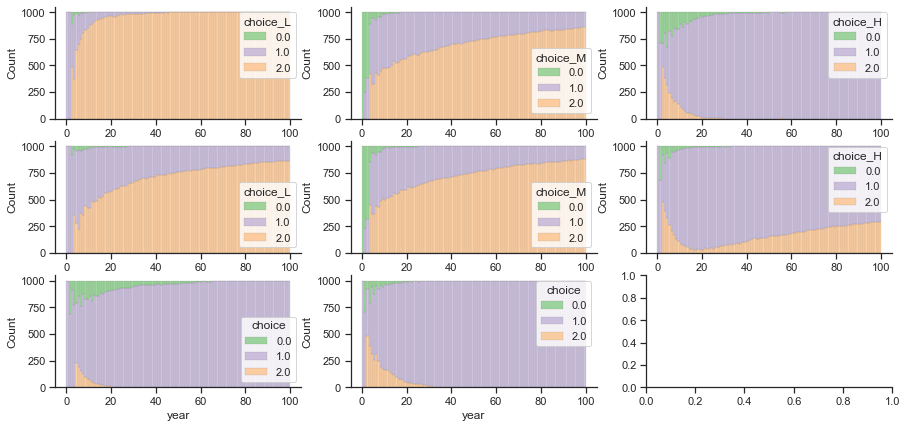

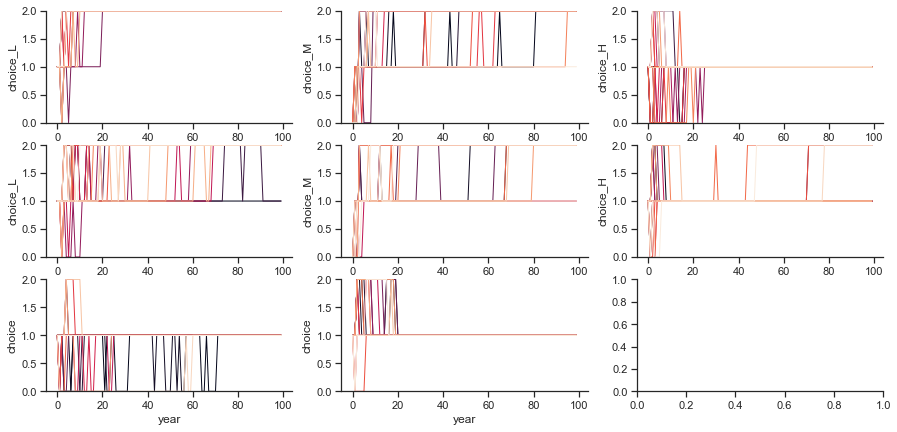

In [95]:
hist_time(2, 1)
line_time(2, 1, 20)

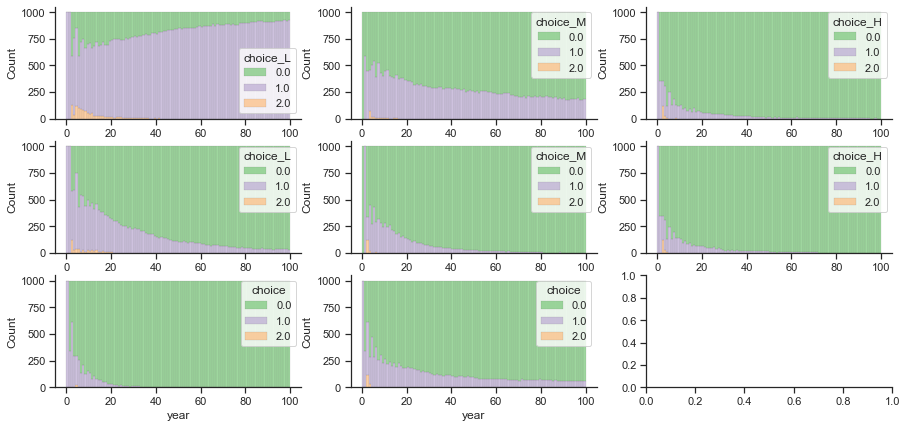

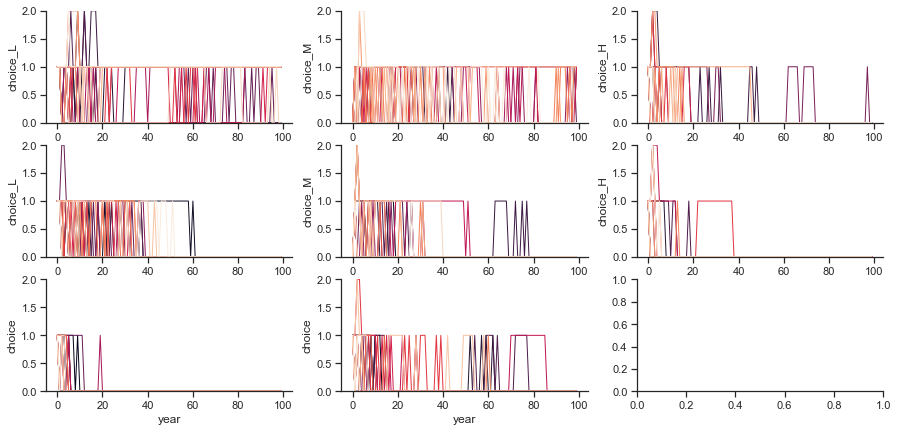

In [96]:
hist_time(0, 2)
line_time(0, 2, 20)

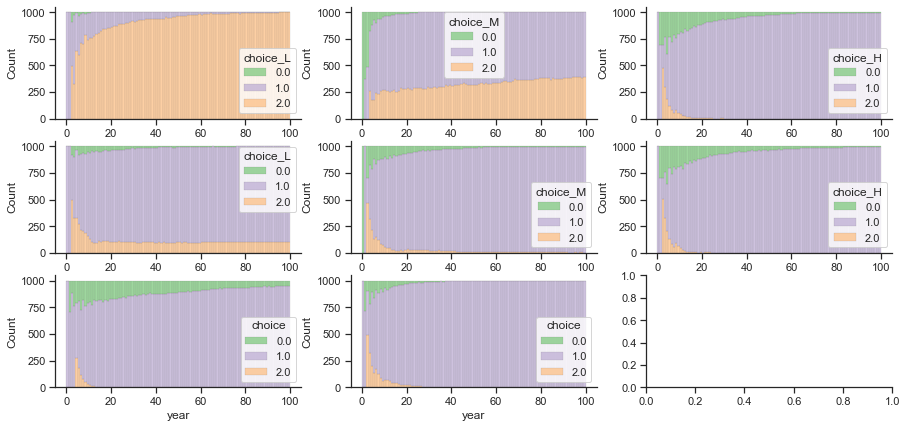

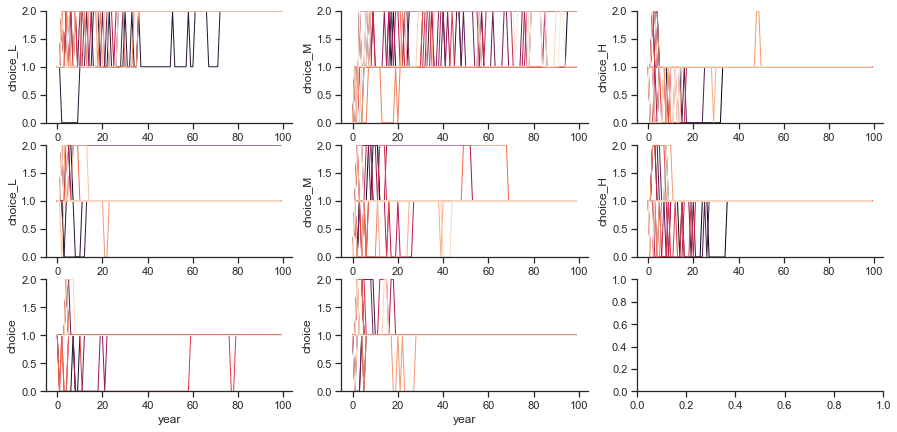

In [97]:
hist_time(1, 2)
line_time(1, 2, 20)

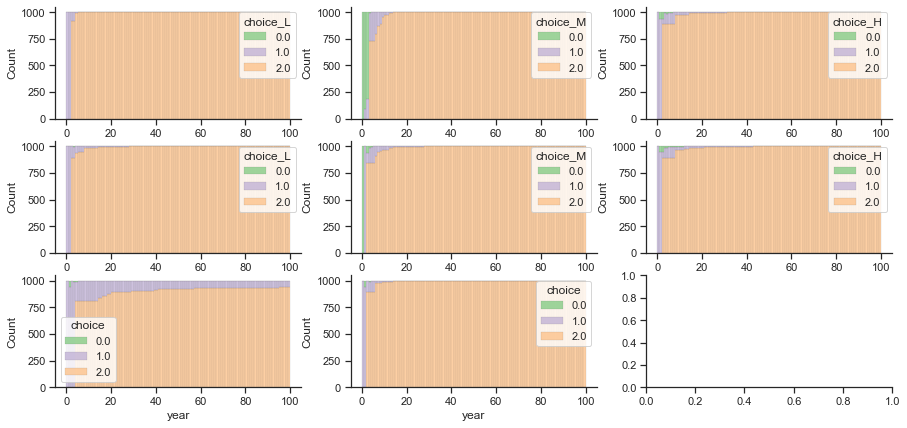

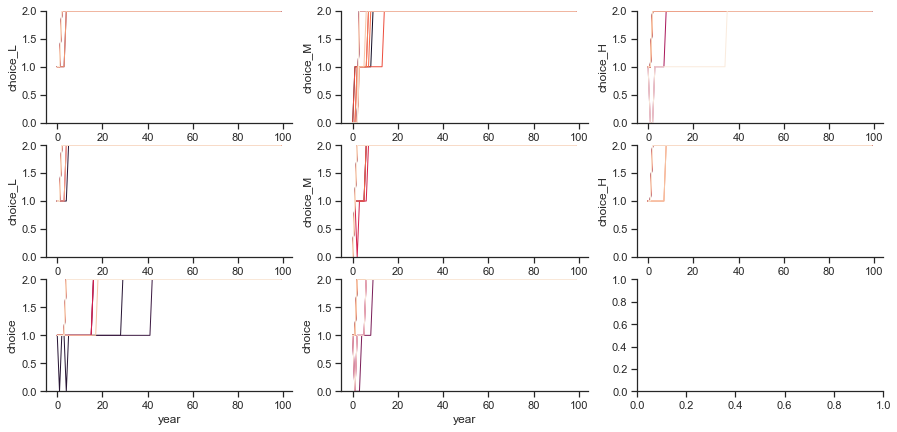

In [98]:
hist_time(2, 2)
line_time(2, 2, 20)